# VG - Assessment - Welliver

Greg Welliver   

In [107]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as plticker
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from numpy import mean
from numpy import std
from functools import partial
%matplotlib inline
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from scipy import stats

from sklearn.datasets import fetch_openml
from sklearn import linear_model, preprocessing, tree, svm, datasets, metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_tweedie_deviance, make_scorer


import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import warnings
from subprocess import call
from IPython.display import Image
from datetime import datetime, timedelta, date
import os
import plotly.graph_objects as go
import itertools
from io import StringIO  
import pydotplus

# Seaborn settings
sns.set_context('notebook')
#sns.set_style("whitegrid")
#sns.set_style("white")
style_set = sns.set_style('whitegrid')
pd.options.display.float_format = '{:,}'.format
color_choice1 = 'plum'
color_choice2 = 'lightblue'
color_choice3 = 'lightgreen'
color_choice4 = 'blue'
#ax.yaxis.set_major_formatter('{x:,.0f}')
#sns.set_context('notebook', font_scale = 4)

#from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

from sklearn.feature_extraction.text import CountVectorizer
from ydata_profiling import ProfileReport
from pandas.plotting import scatter_matrix

## Load the data



In [2]:
# load the data
dfe = pd.read_csv("email.csv")
dfd = pd.read_csv("demos.csv")

# X = pd.concat([X_train, X_test])
# y = pd.concat([y_train, y_test])

# eval_set = [(X_train, y_train), (X_test, y_test)]

#df = pd.read_parquet("../Data/all_storm_data11.pqt")

First I'll look at the email dataset

In [3]:
# check shape
dfe.shape

(41767, 4)

In [4]:
# ensure that aren't duplicate IDs
dfe.nunique()

part_id      41767
click_dt       365
bounce_dt        9
open_dt        372
dtype: int64

In [5]:
dfe.head(10)

,part_id,click_dt,bounce_dt,open_dt
0,1054161513,NaN,NaN,NaN
1,5761909860,NaN,NaN,NaN
2,9130086586,NaN,NaN,NaN
3,5496433327,NaN,NaN,NaN
4,8917877079,NaN,NaN,12/14/2020 0:00
5,2290016446,NaN,NaN,NaN
6,2057483407,1/10/2021 0:00,NaN,12/16/2020 0:00
7,2589661237,NaN,NaN,NaN
8,7772898223,NaN,NaN,NaN
9,6396357382,NaN,NaN,NaN


In [6]:
dfe.value_counts()

part_id     click_dt         bounce_dt       open_dt        
929930576   12/5/2020 0:00   8/25/2020 7:55  9/19/2020 0:00     1
1624504676  12/9/2020 0:00   8/25/2020 7:48  11/29/2020 0:00    1
1977756520  11/16/2020 0:00  7/30/2020 5:30  11/12/2020 0:00    1
2541629799  10/19/2020 0:00  8/18/2020 6:04  10/14/2020 0:00    1
4470791647  12/31/2020 0:00  8/25/2020 7:48  8/15/2020 0:00     1
6483195957  1/25/2021 0:00   7/30/2020 5:30  9/22/2020 0:00     1
8119335137  12/20/2020 0:00  8/29/2020 7:20  11/26/2020 0:00    1
8890838825  1/8/2021 0:00    7/30/2020 5:30  11/12/2020 0:00    1
9428035314  1/14/2021 0:00   7/30/2020 5:30  10/20/2020 0:00    1
9576372771  2/9/2021 0:00    7/30/2020 5:30  1/13/2021 0:00     1
dtype: int64

##### Observations:
- It appears that when an event occurred (e.g. click_dt), the date is populated in the relevant column.  In the case of the bounced emails, it apperas a time is also tracked. Otherwise, if an event never occurs for a participant, the column shows as null.

In [7]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41767 entries, 0 to 41766
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   part_id    41767 non-null  int64 
 1   click_dt   10507 non-null  object
 2   bounce_dt  31 non-null     object
 3   open_dt    21020 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [60]:
# lambda functions to create columns for email analytics
dfe['clicked_email'] = dfe['click_dt'].apply(lambda x: 1 if pd.notnull(x) else 0)
dfe['bounced_email'] = dfe['bounce_dt'].apply(lambda x: 1 if pd.notnull(x) else 0)
dfe['opened_email'] = dfe['open_dt'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [9]:
dfe.head(20)

,part_id,click_dt,bounce_dt,open_dt,clicked_email,bounced_email,opened_email
0,1054161513,NaN,NaN,NaN,0,0,0
1,5761909860,NaN,NaN,NaN,0,0,0
2,9130086586,NaN,NaN,NaN,0,0,0
3,5496433327,NaN,NaN,NaN,0,0,0
4,8917877079,NaN,NaN,12/14/2020 0:00,0,0,1
5,2290016446,NaN,NaN,NaN,0,0,0
6,2057483407,1/10/2021 0:00,NaN,12/16/2020 0:00,1,0,1
7,2589661237,NaN,NaN,NaN,0,0,0
8,7772898223,NaN,NaN,NaN,0,0,0
9,6396357382,NaN,NaN,NaN,0,0,0


Now I'll look at the demos dataset

In [10]:
# check shape
dfd.shape

(41767, 10)

In [11]:
# ensure that aren't duplicate IDs
dfd.nunique()

part_id     41767
fund_ct         8
logon_ct       10
call_ct         6
balance     41613
tenure         79
age            60
gender          3
status          4
campaign        3
dtype: int64

In [12]:
dfd.head(10)

,part_id,fund_ct,logon_ct,call_ct,balance,tenure,age,gender,status,campaign
0,1054161513,6,11,1,"70,377.57",6.0,44.2,0,0,0
1,5761909860,7,13,2,"63,505.69",6.6,44.2,0,1,1
2,9130086586,6,13,2,"55,933.94",5.9,43.7,1,0,1
3,5496433327,6,12,2,"81,072.63",5.5,45.5,0,1,1
4,8917877079,8,12,0,"87,534.41",3.8,45.3,1,0,0
5,2290016446,8,13,0,"58,230.81",7.7,46.9,1,1,0
6,2057483407,6,11,0,"62,525.32",6.0,45.3,0,0,0
7,2589661237,6,12,0,"62,312.19",6.7,44.2,0,0,0
8,7772898223,7,12,2,"72,888.63",6.1,44.1,1,0,1
9,6396357382,6,12,2,"40,425.5",7.2,44.4,0,0,1


# <font color='red'>re-run for final**</font>

profile = ProfileReport(dfd)
profile

##### Observations on dataset
- No missing values nor duplicates
- Appears to be high correlation between fund_ct and status, and call_ct and campaign.  Will investigate this and determine best path forward.
- There were some outliers that may need to be addressed (e.g. in fund_ct, and logon_ct); will check to see if removing them imporves modeling
- balance: there are three negative balances, which doesn't seem logical. Thsi could be a data issue, or an accounting nuance
- generally the features were reasonably well distributed. Not perfectly normal, but not skewed in a way that is overly concerning.
- tenure: generally shows a normal distribution, however there are some strange dips in certain tenure periods. could be caused by something like seasonal acquisition of participants?
- age: there is a peak in participants at one particular age - will need to investigate
- gender: one value is unknown - it may make sense to amend this to either male or female.  gender data is also highly imbalanced towards males.
- status: should only be values for 0 and 1, but there are 11 values that are either 2 or 3.  will need to modify this.
- campaign: In theory this variable should have been split into thirds - i.e. one-third received Email A, one-third received Email B, one-third did not receive the email.  Instead many more participants received Email B

Before addressing the issues called out above, I will merge the the two files on part_id

In [13]:
df = dfd.merge(dfe[['click_dt', 'bounce_dt', 'open_dt', 'clicked_email', 'bounced_email', 'opened_email']], how = 'left',
                left_on = 'part_id', right_on = dfe['part_id'])


In [14]:
# check shape to ensure merge went correctly
df.shape

(41767, 16)

In [15]:
df.head(10)

,part_id,fund_ct,logon_ct,call_ct,balance,tenure,age,gender,status,campaign,click_dt,bounce_dt,open_dt,clicked_email,bounced_email,opened_email
0,1054161513,6,11,1,"70,377.57",6.0,44.2,0,0,0,NaN,NaN,NaN,0,0,0
1,5761909860,7,13,2,"63,505.69",6.6,44.2,0,1,1,NaN,NaN,NaN,0,0,0
2,9130086586,6,13,2,"55,933.94",5.9,43.7,1,0,1,NaN,NaN,NaN,0,0,0
3,5496433327,6,12,2,"81,072.63",5.5,45.5,0,1,1,NaN,NaN,NaN,0,0,0
4,8917877079,8,12,0,"87,534.41",3.8,45.3,1,0,0,NaN,NaN,12/14/2020 0:00,0,0,1
5,2290016446,8,13,0,"58,230.81",7.7,46.9,1,1,0,NaN,NaN,NaN,0,0,0
6,2057483407,6,11,0,"62,525.32",6.0,45.3,0,0,0,1/10/2021 0:00,NaN,12/16/2020 0:00,1,0,1
7,2589661237,6,12,0,"62,312.19",6.7,44.2,0,0,0,NaN,NaN,NaN,0,0,0
8,7772898223,7,12,2,"72,888.63",6.1,44.1,1,0,1,NaN,NaN,NaN,0,0,0
9,6396357382,6,12,2,"40,425.5",7.2,44.4,0,0,1,NaN,NaN,NaN,0,0,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41767 entries, 0 to 41766
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   part_id        41767 non-null  int64  
 1   fund_ct        41767 non-null  int64  
 2   logon_ct       41767 non-null  int64  
 3   call_ct        41767 non-null  int64  
 4   balance        41767 non-null  float64
 5   tenure         41767 non-null  float64
 6   age            41767 non-null  float64
 7   gender         41767 non-null  int64  
 8   status         41767 non-null  int64  
 9   campaign       41767 non-null  int64  
 10  click_dt       10507 non-null  object 
 11  bounce_dt      31 non-null     object 
 12  open_dt        21020 non-null  object 
 13  clicked_email  41767 non-null  int64  
 14  bounced_email  41767 non-null  int64  
 15  opened_email   41767 non-null  int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 5.4+ MB


In [87]:
df_numeric = df[['fund_ct', 'logon_ct', 'call_ct', 'balance', 'tenure', 'age']]

In [18]:
# use a scatter matrix to check if variables are normally distributed, as well see if there is correlation between variables
#scatter_matrix(df_numeric, figsize=(12,12));

In [19]:
df.describe()

,part_id,fund_ct,logon_ct,call_ct,balance,tenure,age,gender,status,campaign,clicked_email,bounced_email,opened_email
count,"41,767.0","41,767.0","41,767.0","41,767.0","41,767.0","41,767.0","41,767.0","41,767.0","41,767.0","41,767.0","41,767.0","41,767.0","41,767.0"
mean,"4,999,553,392.514425",6.291474130294252,12.041300548279743,1.1472214906505136,"60,046.14744870338",6.007113271242807,44.999588191634686,0.27270333038044386,0.3715612804367084,0.7359159144779371,0.25156223813058154,0.000742212751693921,0.5032681303421361
std,"2,890,176,003.149778",0.7522984929543355,1.0917073082408002,1.0536275854304629,"15,031.505232589734",1.0014979042285477,0.914382424920391,0.44540864222438287,0.48387147259828966,0.6390228118878366,0.43391610527699576,0.027233795722884768,0.4999953047764535
min,"133,214.0",5.0,10.0,0.0,"-7,984.65",1.7,42.7,0.0,0.0,0.0,0.0,0.0,0.0
25%,"2,509,040,208.5",6.0,11.0,0.0,"49,879.16499999999",5.3,44.3,0.0,0.0,0.0,0.0,0.0,0.0
50%,"5,010,378,650.0",6.0,12.0,2.0,"60,043.1",6.0,44.8,0.0,0.0,1.0,0.0,0.0,1.0
75%,"7,506,105,835.0",7.0,13.0,2.0,"70,151.315",6.7,45.7,1.0,1.0,1.0,1.0,0.0,1.0
max,"9,999,917,951.0",12.0,19.0,5.0,"126,301.31",10.0,48.9,2.0,3.0,2.0,1.0,1.0,1.0


In [20]:
# let's look at the accounts with the negative balances
df[df['balance'] < 0]

,part_id,fund_ct,logon_ct,call_ct,balance,tenure,age,gender,status,campaign,click_dt,bounce_dt,open_dt,clicked_email,bounced_email,opened_email
722,8777530917,6,12,2,"-7,984.65",4.3,44.2,0,0,1,1/21/2021 0:00,NaN,8/18/2020 0:00,1,0,1
4098,8257384275,7,13,2,"-2,441.89",3.7,46.6,0,0,1,NaN,NaN,9/20/2020 0:00,0,0,1
33777,7807754094,6,13,2,-945.39,7.3,44.0,0,1,1,NaN,NaN,1/8/2021 0:00,0,0,1


Interestingly, these users do share a number of characteristics.  However, there isn't enough information here to tell us what to do with these negative values, so will leave them as is for now.

Now let's look at the age feature.

''

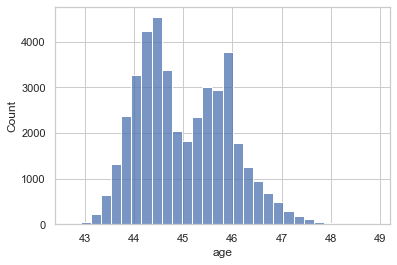

In [77]:
sns.histplot(df['age'], bins=30)
;

In [26]:
df.age.describe()

count             41,767.0
mean    44.999588191634686
std      0.914382424920391
min                   42.7
25%                   44.3
50%                   44.8
75%                   45.7
max                   48.9
Name: age, dtype: float64

Observations:
- The age of partipants has two peaks of concentration - one just above 44, and another right below 46.  There isn't anything to indicate we need to take action on this.

Now let's look at the gender variable

In [51]:
df.gender.value_counts()

0    30378
1    11388
2        1
Name: gender, dtype: int64

With approximately 3/4 of users being male (0), we can change the 2 to a male.

In [52]:
df.head(10)

,part_id,fund_ct,logon_ct,call_ct,balance,tenure,age,gender,status,campaign,click_dt,bounce_dt,open_dt,clicked_email,bounced_email,opened_email
0,1054161513,6,11,1,"70,377.57",6.0,44.2,0,0,0,NaN,NaN,NaN,0,0,0
1,5761909860,7,13,2,"63,505.69",6.6,44.2,0,1,1,NaN,NaN,NaN,0,0,0
2,9130086586,6,13,2,"55,933.94",5.9,43.7,1,0,1,NaN,NaN,NaN,0,0,0
3,5496433327,6,12,2,"81,072.63",5.5,45.5,0,1,1,NaN,NaN,NaN,0,0,0
4,8917877079,8,12,0,"87,534.41",3.8,45.3,1,0,0,NaN,NaN,12/14/2020 0:00,0,0,1
5,2290016446,8,13,0,"58,230.81",7.7,46.9,1,1,0,NaN,NaN,NaN,0,0,0
6,2057483407,6,11,0,"62,525.32",6.0,45.3,0,0,0,1/10/2021 0:00,NaN,12/16/2020 0:00,1,0,1
7,2589661237,6,12,0,"62,312.19",6.7,44.2,0,0,0,NaN,NaN,NaN,0,0,0
8,7772898223,7,12,2,"72,888.63",6.1,44.1,1,0,1,NaN,NaN,NaN,0,0,0
9,6396357382,6,12,2,"40,425.5",7.2,44.4,0,0,1,NaN,NaN,NaN,0,0,0


In [61]:
df = df.replace({'gender' : {2 : 0}})

In [62]:
df.gender.value_counts()

0    30379
1    11388
Name: gender, dtype: int64

Now let's look at status, particularly the observations with values of 2 and 3

In [64]:
df.status.value_counts()

0    26260
1    15496
2       10
3        1
Name: status, dtype: int64

In [73]:
df[df['status'] > 1]

,part_id,fund_ct,logon_ct,call_ct,balance,tenure,age,gender,status,campaign,click_dt,bounce_dt,open_dt,clicked_email,bounced_email,opened_email
152,7516850086,10,13,0,"52,672.42",6.1,45.3,0,2,0,NaN,NaN,12/26/2020 0:00,0,0,1
6294,8240805802,10,14,0,"49,208.07",5.8,45.6,1,2,0,NaN,NaN,NaN,0,0,0
10824,7003760182,10,14,2,"67,210.19",4.9,45.9,0,2,1,NaN,NaN,8/31/2020 0:00,0,0,1
21308,19023600,12,14,2,"68,743.13",3.8,45.2,0,3,1,NaN,NaN,NaN,0,0,0
22096,6171115134,10,14,2,"55,415.72",4.9,45.5,0,2,1,NaN,NaN,NaN,0,0,0
23966,1308847735,10,11,0,"50,525.16",6.2,44.6,1,2,0,NaN,NaN,10/8/2020 0:00,0,0,1
25393,2312010671,11,13,0,"98,305.47",4.2,45.2,0,2,0,NaN,NaN,12/6/2020 0:00,0,0,1
29543,144075218,10,14,2,"76,822.55",6.5,45.8,0,2,1,NaN,NaN,NaN,0,0,0
32253,7368219117,10,13,2,"74,100.24",6.3,45.4,0,2,1,NaN,NaN,NaN,0,0,0
32660,951702405,10,14,0,"53,451.75",6.5,45.8,0,2,0,NaN,NaN,NaN,0,0,0


In [72]:
df[df['status'] > 1].describe()

,part_id,fund_ct,logon_ct,call_ct,balance,tenure,age,gender,status,campaign,clicked_email,bounced_email,opened_email
count,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
mean,"4,403,247,039.272727",10.272727272727273,13.363636363636363,1.0909090909090908,"63,533.908181818195",5.663636363636363,45.40909090909091,0.18181818181818182,2.090909090909091,0.5454545454545454,0.09090909090909091,0.0,0.45454545454545453
std,"3,395,593,346.195074",0.6466697906828633,0.9244162777371754,1.044465935734187,"15,236.432901480464",1.0557203486461053,0.3727050991187132,0.4045199174779452,0.30151134457776363,0.5222329678670935,0.30151134457776363,0.0,0.5222329678670934
min,"19,023,600.0",10.0,11.0,0.0,"49,208.07",3.8,44.6,0.0,2.0,0.0,0.0,0.0,0.0
25%,"1,130,275,070.0",10.0,13.0,0.0,"52,545.354999999996",4.9,45.2,0.0,2.0,0.0,0.0,0.0,0.0
50%,"6,171,115,134.0",10.0,14.0,2.0,"55,415.72",6.1,45.4,0.0,2.0,1.0,0.0,0.0,0.0
75%,"7,383,763,299.5",10.0,14.0,2.0,"71,421.685",6.4,45.7,0.0,2.0,1.0,0.0,0.0,1.0
max,"8,240,805,802.0",12.0,14.0,2.0,"98,305.47",7.1,45.9,1.0,3.0,1.0,1.0,0.0,1.0


In [70]:
df[df['status'] == 1].describe()

,part_id,fund_ct,logon_ct,call_ct,balance,tenure,age,gender,status,campaign,clicked_email,bounced_email,opened_email
count,"15,496.0","15,496.0","15,496.0","15,496.0","15,496.0","15,496.0","15,496.0","15,496.0","15,496.0","15,496.0","15,496.0","15,496.0","15,496.0"
mean,"4,991,290,184.14978",6.63093701600413,12.093443469282395,1.1509421786267424,"60,012.99096992763",6.0178239545688905,45.03008518327333,0.27219927723283427,1.0,0.7379969024264327,0.25761486835312336,0.0,0.5097444501806918
std,"2,884,583,120.023159",0.6397769453654293,0.9883050851669655,1.0546213928688917,"15,045.663538693912",1.0039912933799857,0.8074209810837794,0.44510629732335755,0.0,0.6386632651892241,0.4373348723942828,0.0,0.4999211675849427
min,"550,202.0",5.0,10.0,0.0,-945.39,1.7,43.1,0.0,1.0,0.0,0.0,0.0,0.0
25%,"2,498,054,410.0",6.0,12.0,0.0,"49,795.72",5.3,44.4,0.0,1.0,0.0,0.0,0.0,0.0
50%,"5,038,538,169.0",7.0,12.0,2.0,"59,976.575",6.0,44.8,0.0,1.0,1.0,0.0,0.0,1.0
75%,"7,490,526,567.25",7.0,13.0,2.0,"70,115.36499999999",6.7,45.6,1.0,1.0,1.0,1.0,0.0,1.0
max,"9,999,917,951.0",10.0,17.0,5.0,"119,740.24",10.0,48.4,1.0,1.0,2.0,1.0,0.0,1.0


In [71]:
df[df['status'] == 0].describe()

,part_id,fund_ct,logon_ct,call_ct,balance,tenure,age,gender,status,campaign,clicked_email,bounced_email,opened_email
count,"26,260.0","26,260.0","26,260.0","26,260.0","26,260.0","26,260.0","26,260.0","26,260.0","26,260.0","26,260.0","26,260.0","26,260.0","26,260.0"
mean,"5,004,679,289.190137",6.089489718202589,12.00997715156131,1.145049504950495,"60,064.252072733674",6.000936785986293,44.98142041127213,0.272962680883473,0.0,0.7347677075399848,0.24805788271134807,0.0011805026656511806,0.4994668697638995
std,"2,893,334,826.4427896",0.7369127828004118,1.1470134341876108,1.0530775883136307,"15,023.436425155984",0.9999630016207123,0.9716732290012007,0.4454903066192829,0.0,0.6392846871253235,0.4318938212356549,0.034338811600776495,0.5000092362213832
min,"133,214.0",5.0,10.0,0.0,"-7,984.65",1.9,42.7,0.0,0.0,0.0,0.0,0.0,0.0
25%,"2,519,329,786.5",6.0,11.0,0.0,"49,934.8775",5.3,44.1,0.0,0.0,0.0,0.0,0.0,0.0
50%,"4,993,191,301.5",6.0,12.0,2.0,"60,075.815",6.0,44.9,0.0,0.0,1.0,0.0,0.0,0.0
75%,"7,517,883,960.0",6.0,13.0,2.0,"70,163.63",6.7,45.7,1.0,0.0,1.0,0.0,0.0,1.0
max,"9,999,846,884.0",10.0,19.0,5.0,"126,301.31",10.0,48.9,1.0,0.0,2.0,1.0,1.0,1.0


There doesn't appear to be any strong evidence to assign the observations in question to be either 0 or 1, so I will make them zeroes, since that represents about two-thirds of the values.

In [75]:
df = df.replace({'status' : {2 : 0, 3 : 0}})

In [76]:
df.status.value_counts()

0    26271
1    15496
Name: status, dtype: int64

Let's look at the tenure variable

''

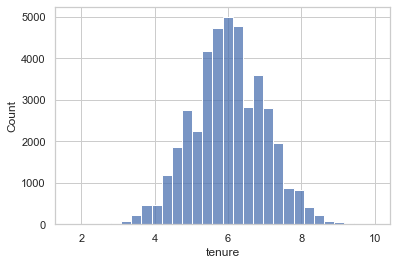

In [84]:
sns.histplot(df['tenure'], bins=30)
;

In [79]:
df.tenure.value_counts()

6.1    1702
5.7    1659
6.0    1655
6.2    1650
5.9    1637
       ... 
9.5       3
9.6       2
1.7       1
1.9       1
2.1       1
Name: tenure, Length: 79, dtype: int64

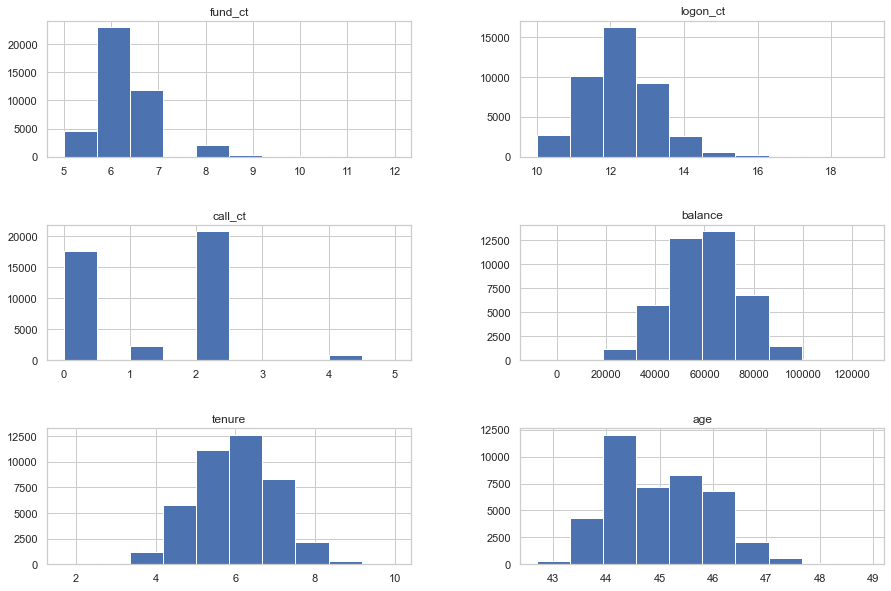

In [88]:
df_numeric.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

''

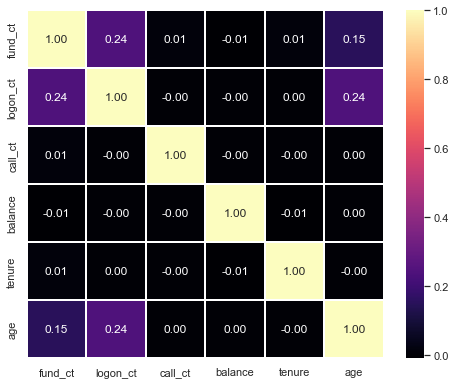

In [89]:
corrmat = df_numeric.corr()
f, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap='magma',fmt='.2f',
                 linewidths=.05)

f.subplots_adjust(top=0.93)
;


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41767 entries, 0 to 41766
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   part_id        41767 non-null  int64  
 1   fund_ct        41767 non-null  int64  
 2   logon_ct       41767 non-null  int64  
 3   call_ct        41767 non-null  int64  
 4   balance        41767 non-null  float64
 5   tenure         41767 non-null  float64
 6   age            41767 non-null  float64
 7   gender         41767 non-null  int64  
 8   status         41767 non-null  int64  
 9   campaign       41767 non-null  int64  
 10  click_dt       10507 non-null  object 
 11  bounce_dt      31 non-null     object 
 12  open_dt        21020 non-null  object 
 13  clicked_email  41767 non-null  int64  
 14  bounced_email  41767 non-null  int64  
 15  opened_email   41767 non-null  int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 5.4+ MB


# <font color='orange'>Modeling</font>

In [94]:
# drop unnecessary columns
df = df.drop(['part_id', 'click_dt', 'bounce_dt', 'open_dt'], axis=1)

## Create dummy variables for categorical data types

# isolate categorical variables
categorical_features = df.select_dtypes(include=['object'])

df = pd.concat([df.drop(categorical_features, axis=1), pd.get_dummies(categorical_features)], axis=1)


In [95]:

### Split data into training and testing subsets

# Create the X and y matrices from the dataframe
X = df.drop(columns = ['clicked_email'])
y = df['clicked_email']

# from sklearn.model_selection import train_test_split; reserve 20% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1234)

#X_train.isna().sum().sum()

In [112]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [21]:
blah blah

SyntaxError: invalid syntax (2021581288.py, line 1)

# <font color='orange'>Logistic Regression</font>

In [96]:
lr_clf = LogisticRegression(random_state = 23)
lr_clf.fit(X_train, y_train.values.ravel())
print("Classification Report for Training Data")
print(classification_report(y_train, lr_clf.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, lr_clf.predict(X_test)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     25020
           1       1.00      0.00      0.00      8393

    accuracy                           0.75     33413
   macro avg       0.87      0.50      0.43     33413
weighted avg       0.81      0.75      0.64     33413

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.75      1.00      0.85      6240
           1       0.00      0.00      0.00      2114

    accuracy                           0.75      8354
   macro avg       0.37      0.50      0.43      8354
weighted avg       0.56      0.75      0.64      8354



#### Let's also look at a confusion matrix

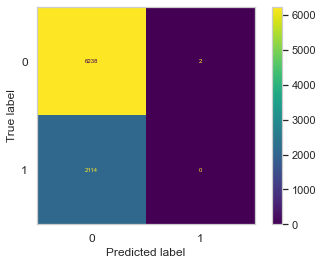

In [100]:
y_pred = lr_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = lr_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['0', '1'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['0', '1'], fontsize = 12)
ax.set_yticklabels(labels = ['0', '1'], fontsize = 12)
plt.grid(False)
plt.rcParams.update({'font.size': 6})
display_cm.plot(ax = ax);

# <font color='orange'>Random Forest Model</font>


In [101]:
# using 3 estimators
rf_clf = RandomForestClassifier(random_state = 123, n_jobs=-1)
rf_clf.fit(X_train, y_train.values.ravel())
y_pred = rf_clf.predict(X_test)

# let's look at classification report
print("Classification Report for Training Data")
print(classification_report(y_train, rf_clf.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, rf_clf.predict(X_test)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25020
           1       1.00      1.00      1.00      8393

    accuracy                           1.00     33413
   macro avg       1.00      1.00      1.00     33413
weighted avg       1.00      1.00      1.00     33413

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      6240
           1       0.49      0.46      0.48      2114

    accuracy                           0.74      8354
   macro avg       0.66      0.65      0.65      8354
weighted avg       0.74      0.74      0.74      8354



In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

11


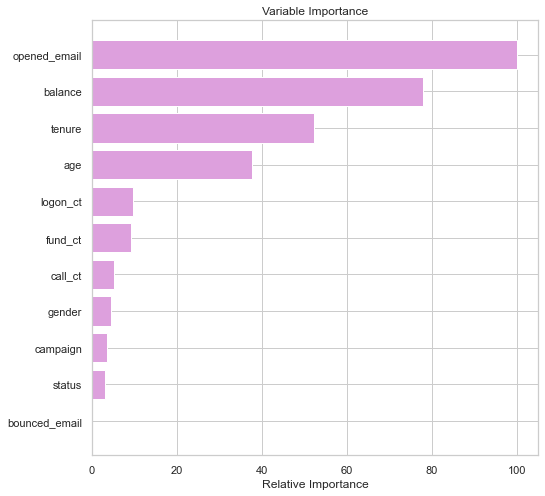

In [103]:
feature_importance = rf_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Now hyperparameter tuning

In [ ]:
# set the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 9],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [5, 10, 20, 50, 100]
}

In [ ]:
#markdown since it takes so long to run
# %%time
# rscv_rf = RandomizedSearchCV(RandomForestRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# rscv_rf.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [ ]:
rf_reg_cv = RandomForestRegressor(max_depth=6, max_features=None, min_samples_leaf=10,
                      n_estimators=150, random_state=1234, n_jobs=-1, criterion='squared_error')
rf_reg_cv.fit(X_train, y_train.values.ravel())

y_pred = rf_reg_cv.predict(X_train)
#y_pred = rscv_rf.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = rf_reg_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
feature_importance = rf_reg_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
lgbm = LGBMRegressor(random_state=1234, metric='rmse')

# <font color='orange'>Light GBM</font>

In [114]:
# using 3 estimators
lgbm = LGBMClassifier(random_state = 123, n_jobs=-1)
#lgbm.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

# let's look at classification report
print("Classification Report for Training Data")
print(classification_report(y_train, rf_clf.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, rf_clf.predict(X_test)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25020
           1       1.00      1.00      1.00      8393

    accuracy                           1.00     33413
   macro avg       1.00      1.00      1.00     33413
weighted avg       1.00      1.00      1.00     33413

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      6240
           1       0.49      0.46      0.48      2114

    accuracy                           0.74      8354
   macro avg       0.66      0.65      0.65      8354
weighted avg       0.74      0.74      0.74      8354



11


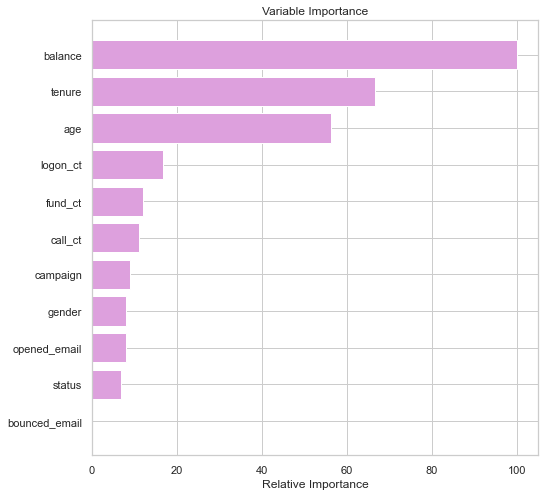

In [111]:
feature_importance = lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

With this baseline, let's see how we can improve with hyperparameter tuning

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'num_leaves': [10, 30, 50],
    'colsample_bytree': [.3, .5, .8]
}

In [ ]:
# %%time
# markdown since it takes so long to run
# rscv_lgbm = RandomizedSearchCV(LGBMRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# rscv_lgbm.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [ ]:
# define the model with hyperparamters from random search
lgbm_cv = LGBMRegressor(colsample_bytree=0.5, max_depth=9, n_estimators=150,
              num_leaves=30, random_state=1234, metric='rmse')
lgbm_cv.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

y_pred = lgbm_cv.predict(X_train)
#y_pred = rscv_lgbm.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = lgbm.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

In [ ]:
feature_importance = lgbm_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### cross validation

In [ ]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1234, shuffle=True)

#build multiple linear regression model
#model = LGBMRegressor(random_state=1234)
model = LGBMRegressor(random_state=1234)


#use k-fold CV to evaluate model
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print(f"{mean(abs(scores)):,.1f}")

first run: 

model = LGBMRegressor(colsample_bytree=0.5, max_depth=9, n_estimators=150,
              num_leaves=30, random_state=1234)



RMSE: 131,769.0


second model: 

model = LGBMRegressor(random_state=1234)


RMSE: 131,653.8


# <font color='orange'>XGBoost</font>


In [ ]:
# define the model
xgbr = XGBRegressor(random_state=1234, early_stopping_rounds=20, eval_metric='rmse')
xgbr.fit(X_train, y_train, eval_set=eval_set)

y_pred = xgbr.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = xgbr.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

In [ ]:
feature_importance = xgbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'colsample_bytree': [.3, .5, .8],
    'subsample': [.3, .5, .8]
}

In [ ]:
# %%time
# markdown since it takes so long to run
# rscv_xgb = RandomizedSearchCV(XGBRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# rscv_xgb.fit(X_train, y_train.values.ravel(), eval_set=eval_set)
# print(random_search.best_estimator_)

In [ ]:
# define the model
xgbr_cv = XGBRegressor(random_state=1234, eval_metric='rmse',
                       learning_rate=0.1, 
                       max_depth=6, 
                       n_estimators=150,
                       colsample_bytree=.8,
                       subsample=.8)
xgbr_cv.fit(X_train, y_train, eval_set=eval_set)

y_pred = xgbr_cv.predict(X_train)
#y_pred = rscv_xgb.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = xgbr_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

In [ ]:
feature_importance = xgbr_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# <font color='orange'>Tweedie Regression</font>


Steps:
- Filter out claims with zero amount, as the severity model requires strictly positive target values.
- Correct for unreasonable observations (that might be data error) and a few exceptionally large claim amounts
    

In [ ]:
# load the data - this dataset has the zeroes eliminated
### comment out since current run doesn't contain any zeroes nor outliers
# X_train = pd.read_parquet("../Data/X_train_td.pqt")
# X_test = pd.read_parquet("../Data/X_test_td.pqt")
# y_train = pd.read_parquet("../Data/y_train_td.pqt") 
# y_test = pd.read_parquet("../Data/y_test_td.pqt")

# X = pd.concat([X_train, X_test])
# y = pd.concat([y_train, y_test])

In [ ]:
# tdrg = linear_model.TweedieRegressor(max_iter=500)
tdrg = TweedieRegressor(max_iter=500)
tdrg.fit(X_train, y_train.values.ravel())
# make predictions for test data
y_pred = tdrg.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = tdrg.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
param_grid = {
    'power': [0, 1, 2, 3],
    'max_iter': [50, 100, 150, 200, 250, 500, 1000, 1500]
}

In [ ]:
# %time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(linear_model.TweedieRegressor(),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [ ]:
#tdrg_cv = TweedieRegressor(link='log', power=3, max_iter=50)
# tdrg = linear_model.TweedieRegressor(max_iter=500)
tdrg_cv = TweedieRegressor(link='log', power=1, max_iter=50)
tdrg_cv.fit(X_train, y_train.values.ravel())

# make predictions for test data
y_pred = tdrg_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = tdrg_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

In [ ]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

SCRATCH

In [ ]:
# # Create the fifth model
# model_mlr = sm.OLS(y_train, X_train)

# # Fit the model
# model_mlr_result = model_mlr.fit()

# # Evaluate the model
# model_mlr_result.summary()

In [ ]:
# #df = pd.DataFrame(data) 

# x = X
# y = y

# x = sm.add_constant(x)

# model = sm.OLS(y, x).fit()
# predictions = model.predict(x) 

# print_model = model.summary()
# print(print_model)

https://stackoverflow.com/questions/37144913/getting-valueerror-the-indices-for-endog-and-exog-are-not-aligned